In [2]:
# Import the basics for some inital EDA

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns

In [3]:
# Some information I've been given about the data:

##### Columns I have:
## employee_id : id of the employee. Unique by employee per company 
## company_id : company id. 
## dept : employee dept 
## seniority : number of yrs of work experience when hired 
## salary: avg yearly salary of the employee during her tenure within the company 
## join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 
## quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

In [4]:
# Get the data
dc1 = pd.read_csv("employee_retention_data.csv")

In [5]:
# Check data dimensions
print("The data has {0} rows and {1} columns".format(dc1.shape[0], dc1.shape[1]))

The data has 24702 rows and 7 columns


In [6]:
# Take a quick look to see what the data look like
dc1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [7]:
# Confirm column names
list(dc1.columns.values)

['employee_id',
 'company_id',
 'dept',
 'seniority',
 'salary',
 'join_date',
 'quit_date']

In [8]:
# Get info about data types and missingness
dc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
employee_id    24702 non-null float64
company_id     24702 non-null int64
dept           24702 non-null object
seniority      24702 non-null int64
salary         24702 non-null float64
join_date      24702 non-null object
quit_date      13510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [9]:
# Check percentage of missing values in the columns to decide whether to drop, impute, or do something else (logical given what's missing)
miss = dc1.isnull().sum()/len(dc1)
print(type(miss))
miss = miss[miss > 0]
miss.sort_values(inplace = True)
miss
# I know that these data are missing because it means that the people still work there. Don't drop - do something else (later)

<class 'pandas.core.series.Series'>


quit_date    0.453081
dtype: float64

In [10]:
# Now look at the other variables/columns in the dataset
# First look at dept variable
dc1['dept'].unique()
# there are 6

array(['customer_service', 'marketing', 'data_science', 'engineer',
       'sales', 'design'], dtype=object)

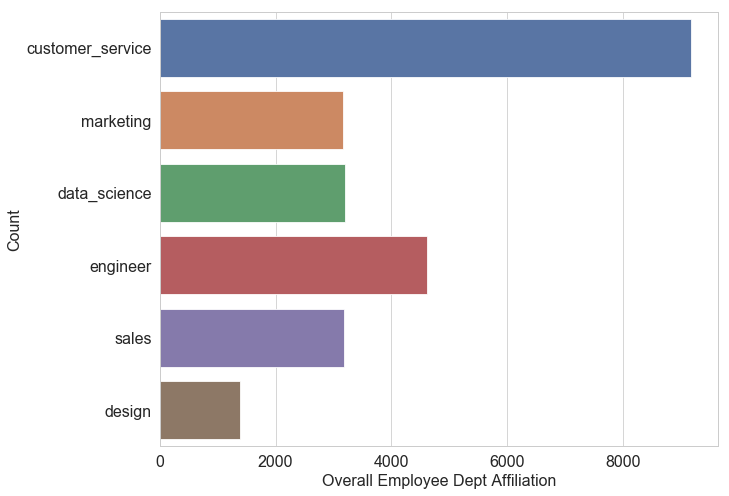

In [11]:
# What is the break down/count of number of employees by department across all companies?
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16, "legend.fontsize": 16, "xtick.labelsize": 16, "ytick.labelsize": 16})
ax = sns.countplot(y="dept", data=dc1) 
ax.set(xlabel='Overall Employee Dept Affiliation', ylabel='Count')
plt.show()

# CONCLUDE:
# Greatest bulk of employees are coming from customer service category. May want to control for this since turnover could appear higher in this department just because of more staff.

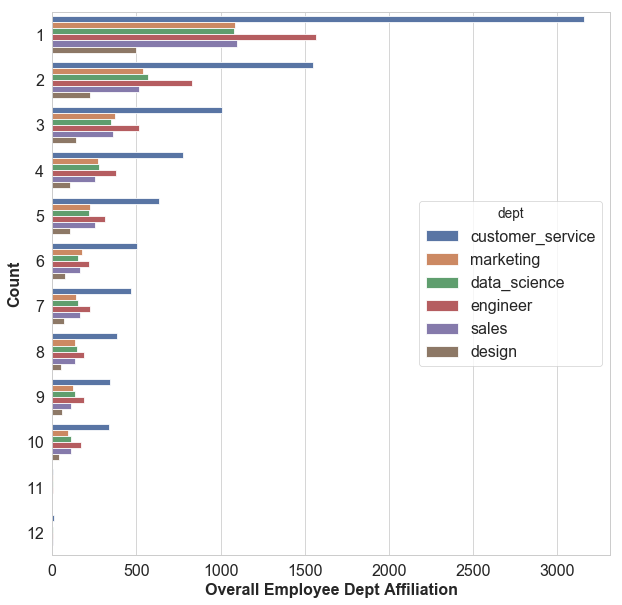

In [206]:
# What is the break down/count of number of employees by department shown for each company separately?
sns.set(style="whitegrid", color_codes=True)
plt.rcParams['figure.figsize'] = (10.0, 10.0)
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16, "legend.fontsize": 16, "xtick.labelsize": 16, "ytick.labelsize": 16})
ax = sns.countplot(y="company_id", hue = "dept", data=dc1) 
ax.set(xlabel='Overall Employee Dept Affiliation', ylabel='Count')
plt.show()

# CONCLUDE:
# Trend observed above seems to also be present in the within company context : most staff are customer service dept, then engineers. Design is the smallest size dept.
# Company 11 and 12 are very different from the rest. May want to think about including them in predictive models since they are outliers across the group and may lead to conclusions that are not generalizable.

In [13]:
# Next look at the seniority variable: 
np.sort(dc1['seniority'].unique())
# It is highly unlikely that someone has a seniority status of 98 or np.sort(dc1['seniority'].unique()). These must be errors. (# years work experience when hired)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 98, 99])

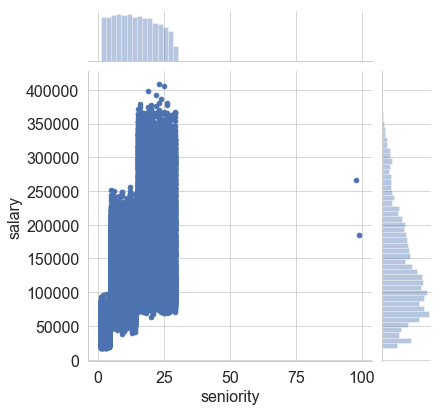

In [14]:
# Quickly, look at seniority and salary relationship (see both distribution/histogram and relationship as well as outliers and where they fall)
sns.jointplot(x="seniority", y="salary", data=dc1)

# CONCLUDE:
# Need to get rid of those outliers - don't have any information on how to correct them.

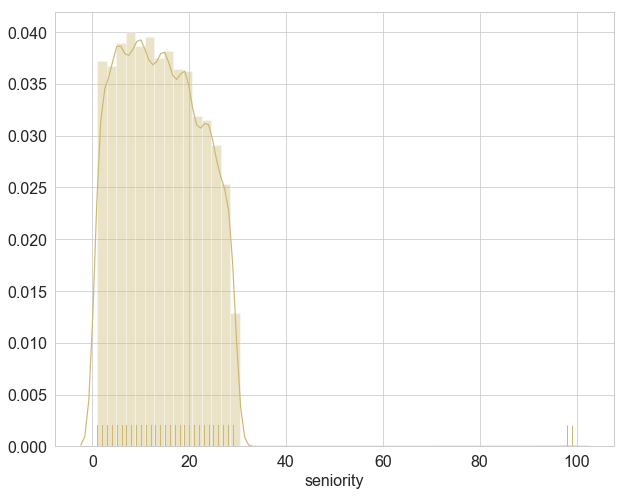

In [15]:
# plot distribution of seniority values - outliers evident here too
sns.distplot(dc1['seniority'], rug = True, color = 'y')

In [16]:
# deal with outliers in seniority column, here only 2, so will remove. Check shape before and after to confirm what's happening
dc1.shape

(24702, 7)

In [17]:
# Process of removing seniority outliers based on being above 3 st deviations of the mean
target = dc1['seniority']
mean = target.mean()
sd = target.std()
reduced_dc1 = dc1[(target > mean - 3*sd) & (target < mean + 3*sd)]
reduced_dc1.shape

# this removed 2 outliers that were beyond 3 sd of the mean.

(24700, 7)

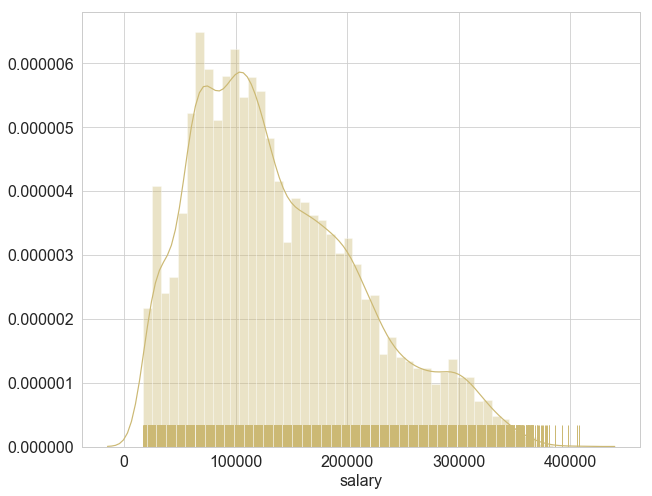

In [18]:
# Now take a look at the variable, salary, by itself
sns.distplot(reduced_dc1['salary'], rug = True, color = 'y')
# looks like some outliers here, too, at the high end. These could interfere with predictions, so consider removing since it's only a few.

In [19]:
## Here applying the same process/criteria for outlier removal in the salary column as I used with the seniority column.
target2 = reduced_dc1['salary']
mean2 = target2.mean()
sd2 = target2.std()
reduced2_dc1 = reduced_dc1[(target2 > mean2 - 3*sd2) & (target2 < mean2 + 3*sd2)]
reduced2_dc1.shape
# As a result, this removed 22 additional data points.

(24678, 7)

In [20]:
# give the new dataframe a more intuitive name after outlier removal from the seniority and salary variables
dc1_NEW = reduced2_dc1

In [21]:
# Our reduced dataframe:
dc1_NEW.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [22]:
# Now, look at company_id variable
dc1_NEW['company_id'].nunique()
# size of companies clearly varies 11 and 12 are smaller than the rest - this could be important in predictions since we really have sparse data for companies 11 and 12.

12

In [23]:
# Now, check the employee_id variable (make sure no duplicate IDs; # rows shoudl = # unique ids)
dc1_NEW['employee_id'].nunique()

24678

In [ ]:
# The next steps will be to join and quit dates: first take a look and then convert them to date/time format consistently in case any are different and subtract to get "tenure" or number days worked.

In [236]:
# First do a quick visual scan to make sure they're all in the same format (although the next steps will switch all to same format)
#dc1_NEW['join_date'].value_counts(dropna = False)

In [237]:
#dc1_NEW['quit_date'].value_counts(dropna = False)

In [26]:
# get all dates in standard format before calculating difference in time to get tenure
import datetime
dc1_NEW['join_date'] = pd.to_datetime(dc1_NEW['join_date'])
dc1_NEW['quit_date'] = pd.to_datetime(dc1_NEW['quit_date'])
dc1_NEW.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [27]:
# Check updated format of date columns
dc1_NEW.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24678 entries, 0 to 24699
Data columns (total 7 columns):
employee_id    24678 non-null float64
company_id     24678 non-null int64
dept           24678 non-null object
seniority      24678 non-null int64
salary         24678 non-null float64
join_date      24678 non-null datetime64[ns]
quit_date      13501 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.5+ MB


In [29]:
# Calcualte a new column for total tenure, which is the time someone has worked at the company
dc1_NEW['total_tenure'] = dc1_NEW['quit_date'] - dc1_NEW['join_date']
dc1_NEW.head()
# string and number are the output of this new column

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days


In [30]:
# Convert the variable total_tenure that was just created so that it only includes the days (integer)
dc1_NEW['days_employeed'] = (dc1_NEW['quit_date'] - dc1_NEW['join_date']).dt.days
dc1_NEW.head()
# just number of days and NaNs in this new column, days_employeed

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040.0


In [32]:
# Change the NAs in the new days_employeed column to something meaningful, because they reflect the fact that people are still employeed!
dc1_NEW['days_employeed'].fillna('currently_employeed', inplace = True)
dc1_NEW.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040


In [33]:
# Also create new columns for start year and month since this could potentiually tell you something about retention of current and future employees (maybe people who start in the winter months stay longer? maybe there is some stochastic or environmental feature that leads to certain years/cohorts being different than others -- and you can't do anything about this)
dc1_NEW['start_year'] = (dc1_NEW['join_date'].dt.year)
dc1_NEW['start_month'] = (dc1_NEW['join_date'].dt.month)
dc1_NEW.head()


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10


In [ ]:
# May also want to take the continuous column/feature called days_employeed and turn it into categorical. Need to first create a new column where it's all numeric (no strings) then bin and assign new categories.


In [34]:
# First, duplicate the column and call it days_employed_cont
dc1_NEW['days_employeed_cont']=dc1_NEW['days_employeed']

# Now, turn the string 'curr_employeed' into a high number 1800 is 5 years so use 1850 since it is above the last date of measure and higher than the other values.
dc1_NEW['days_employeed_cont'] = dc1_NEW['days_employeed_cont'].replace('currently_employeed', 1850) 
dc1_NEW.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0


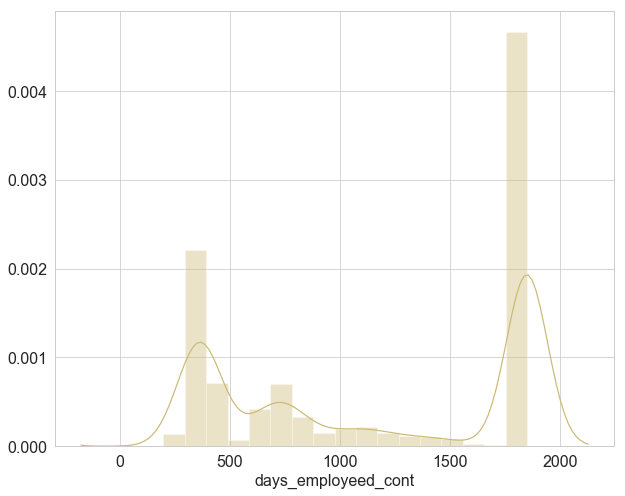

In [36]:
# Now, the column days_employeed_cont is all numeric values, and we can inspect further
sns.distplot(dc1_NEW['days_employeed_cont'], kde=True, rug=False, norm_hist= False, color = 'y')
# looks like at least 4 major natural breakpoints where people worked for 1 year, ~ 2 years, ~ 3 years, or more (our artificaially assigned 1850s are obvious).

In [37]:
# After first trying to use the quartile method, it seems like it might be best to manually cut at thresholds where the density plot suggests major turnover at annual intervals (1 year, 2 years, 3 years, etc.)
bins = [0, 360, 720, 1080, 1440, 1850]
names = ['<1yr', '1-2yr', '2-3yr', '3-4yr', '4+yrs']

# a new column called tenure_category is the binned times/durations that people were employeed. 
dc1_NEW['tenure_category'] = pd.cut(dc1_NEW['days_employeed_cont'], bins, labels=names)
dc1_NEW.head(20)

#print(dc1_NEW.dtypes)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont,tenure_category
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0,1-2yr
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0,<1yr
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0,4+yrs
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0,1-2yr
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0,2-3yr
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578 days,578,2012,1,578.0,1-2yr
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,NaT,currently_employeed,2013,10,1850.0,4+yrs
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,NaT,currently_employeed,2014,3,1850.0,4+yrs
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047 days,1047,2012,12,1047.0,2-3yr
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaT,currently_employeed,2012,6,1850.0,4+yrs


In [42]:
#Also, consider creating a lower resolution, binary column that tellus us just whether they are still empllyeed or not (y/n; 0/1) which I may want to look at later:
dc1_NEW['still_employeed'] = np.where(pd.isnull(dc1_NEW['quit_date']), '1', '0')
dc1_NEW.head(10)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont,tenure_category,still_employeed
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0,1-2yr,0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0,<1yr,0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0,4+yrs,1
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0,1-2yr,0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0,2-3yr,0
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578 days,578,2012,1,578.0,1-2yr,0
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,NaT,currently_employeed,2013,10,1850.0,4+yrs,1
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,NaT,currently_employeed,2014,3,1850.0,4+yrs,1
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047 days,1047,2012,12,1047.0,2-3yr,0
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaT,currently_employeed,2012,6,1850.0,4+yrs,1


In [40]:
#Look at counts of two created groups for still employeed or not to see if they are balanced or not.
dc1_NEW['still_employeed'].value_counts(dropna = False)

0    13501
1    11177
Name: still_employeed, dtype: int64

In [41]:
# Sanity check
dc1_NEW.isnull().sum(axis = 0)

employee_id                0
company_id                 0
dept                       0
seniority                  0
salary                     0
join_date                  0
quit_date              11177
total_tenure           11177
days_employeed             0
start_year                 0
start_month                0
days_employeed_cont        0
tenure_category            0
still_employeed            0
dtype: int64

In [44]:
# I also want to create a salary ranking column in case this is a better predictor than the continuous value. I will do this with the quadrant cut method - 4 equal sized bins will be created at cutoff points.
dc1_NEW['salary_rank']=pd.qcut(dc1_NEW['salary'],4,labels=['low','med','high','very_high'])
dc1_NEW.head(20)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont,tenure_category,still_employeed,salary_rank
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0,1-2yr,0,med
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0,<1yr,0,high
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0,4+yrs,1,med
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0,1-2yr,0,med
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0,2-3yr,0,very_high
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578 days,578,2012,1,578.0,1-2yr,0,high
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,NaT,currently_employeed,2013,10,1850.0,4+yrs,1,med
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,NaT,currently_employeed,2014,3,1850.0,4+yrs,1,low
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047 days,1047,2012,12,1047.0,2-3yr,0,high
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaT,currently_employeed,2012,6,1850.0,4+yrs,1,med


In [70]:
# Similarly, I may want to just compare size of companies - could be important to take this into account later?
total_employees_count = dc1_NEW.groupby(['company_id']).size().reset_index(name='total_number_of_employees')
total_employees_count.head(12)

,company_id,total_number_of_employees
0,1,8472
1,2,4213
2,3,2749
3,4,2062
4,5,1755
5,6,1291
6,7,1224
7,8,1047
8,9,961
9,10,864


In [72]:
total_employees_by_dept = dc1_NEW.groupby(['company_id', 'dept']).size().reset_index(name='number_of_employees_by_dept')
total_employees_by_dept.tail(20) # check tail for those small companies - 11 and 12.

,company_id,dept,number_of_employees_by_dept
50,9,design,60
51,9,engineer,188
52,9,marketing,124
53,9,sales,113
54,10,customer_service,336
55,10,data_science,109
56,10,design,41
57,10,engineer,171
58,10,marketing,96
59,10,sales,111


In [ ]:
########## A few quick visuals to look at how some of the features are potentially related to the target (tenure category, here, with 5 possible classes).

Text(0, 0.5, 'Tenure Category')

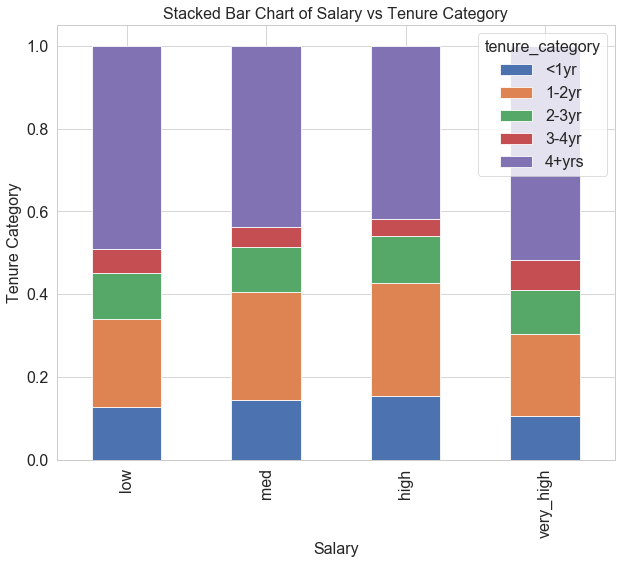

In [45]:
# Salary and tenure category:
table=pd.crosstab(dc1_NEW.salary_rank, dc1_NEW.tenure_category)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Salary vs Tenure Category')
plt.xlabel('Salary')
plt.ylabel('Tenure Category')

# CONCLUDE:
# Really, not stand-out trends. But, it is surprising that the very high salary group has some people (maybe smaller size group than the other categories) that only stay for one year.

Text(0, 0.5, 'Tenure Category')

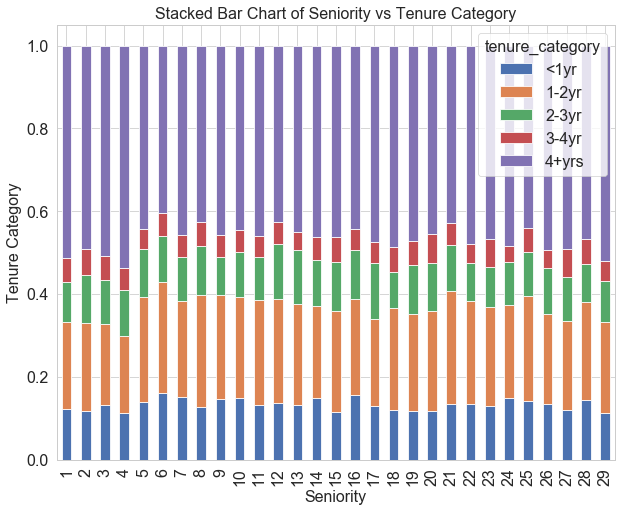

In [46]:
# Seniority and tenure category:
table=pd.crosstab(dc1_NEW.seniority, dc1_NEW.tenure_category)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Seniority vs Tenure Category')
plt.xlabel('Seniority')
plt.ylabel('Tenure Category')

# CONCLUDE:
# No major stand-out trends.

Text(0, 0.5, 'Tenure Category')

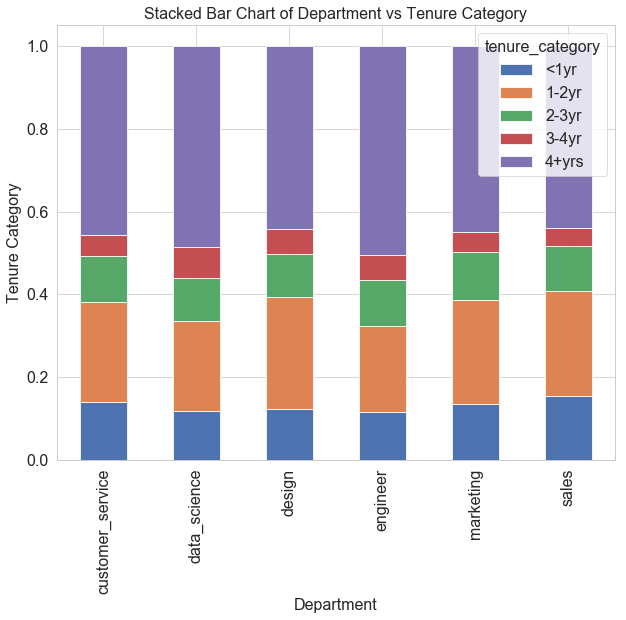

In [47]:
# Department and tenure category:
table=pd.crosstab(dc1_NEW.dept, dc1_NEW.tenure_category)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Department vs Tenure Category')
plt.xlabel('Department')
plt.ylabel('Tenure Category')

# CONCLUDE:
# No real trends here either.

Text(0, 0.5, 'Tenure Category')

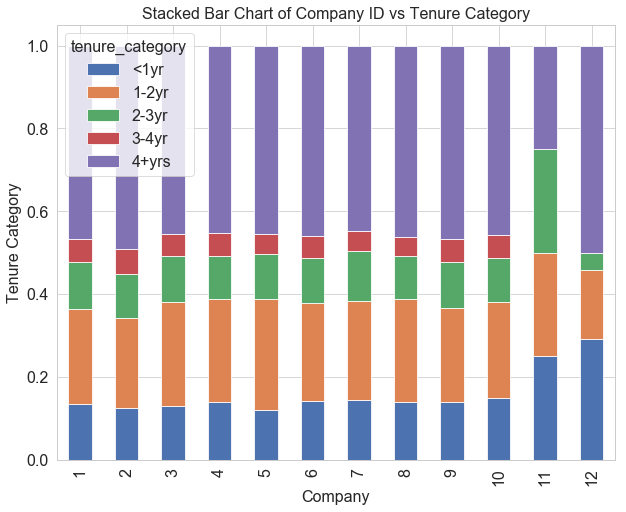

In [48]:
# Company ID and tenure category:
table=pd.crosstab(dc1_NEW.company_id, dc1_NEW.tenure_category)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Company ID vs Tenure Category')
plt.xlabel('Company')
plt.ylabel('Tenure Category')

# CONCLUDE:
# company 11 and 12 really appear different than the others. 
# previously looked at sum of number of employees - counts - need to include this here. Also counts for each department.

In [51]:
# Just to get some real counts for eyeball comparison of employment (y/n) across departments:
counts = dc1_NEW.groupby(['still_employeed'])['dept'].value_counts().values
counts
# what is returned is whether someone is still employeed : 0 or 1 in that order for each of the 6 departments. So for 
# customer service: 5094 not employeed; 2355 employeed... and so on.

array([5094, 2355, 1811, 1782, 1681,  778, 4086, 2245, 1499, 1384, 1361,
        602])

In [238]:
# Now, let's quickly take a look JUST at the people who quit:

past_employees_df = dc1_NEW[dc1_NEW.still_employeed == '0']
#past_employees_df.head(20)

# also check the opposite
#current_employees_df = dc1_NEW[dc1_NEW.still_employeed == '1']
#current_employees_df.head(20)

In [62]:
# Change data types for next step visualizations
past_employees_df["company_id"] = past_employees_df["company_id"].astype(int)
past_employees_df["days_employeed"] = past_employees_df["days_employeed"].astype(int)
past_employees_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13501 entries, 0 to 24699
Data columns (total 15 columns):
employee_id            13501 non-null float64
company_id             13501 non-null int64
dept                   13501 non-null object
seniority              13501 non-null int64
salary                 13501 non-null float64
join_date              13501 non-null datetime64[ns]
quit_date              13501 non-null datetime64[ns]
total_tenure           13501 non-null timedelta64[ns]
days_employeed         13501 non-null int64
start_year             13501 non-null int64
start_month            13501 non-null int64
days_employeed_cont    13501 non-null float64
tenure_category        13501 non-null category
still_employeed        13501 non-null object
salary_rank            13501 non-null category
dtypes: category(2), datetime64[ns](2), float64(3), int64(5), object(2), timedelta64[ns](1)
memory usage: 2.1+ MB


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


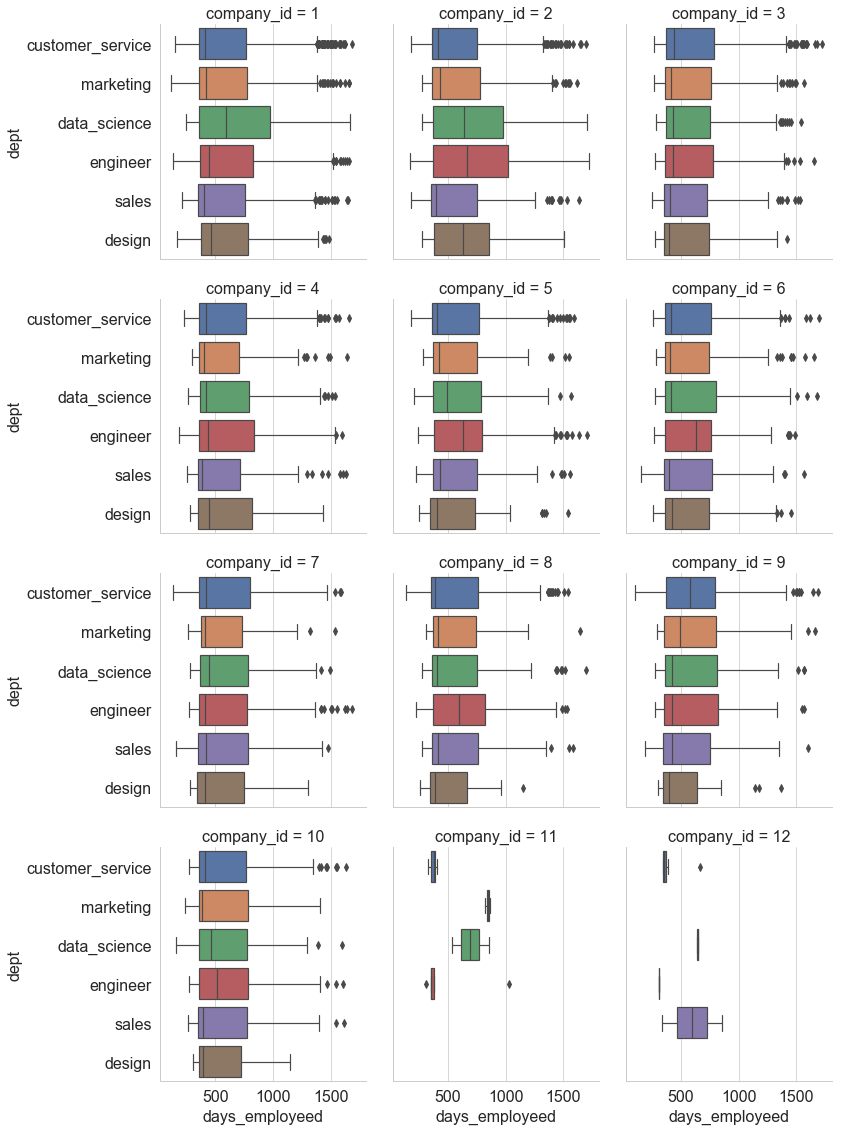

In [63]:
# Let's visualize days employeed by department and company for this past employees dataframe (just those who quit; not those who are still working):
g = sns.catplot(x="days_employeed", y="dept", col="company_id", data=past_employees_df, kind="box", col_wrap = 3, height = 4, aspect = 1, sharey=True)

# CONCLUDE:
# For the people who *have* quit, iut doesn't look like there's a huge departmental difference in number of days people stayed.
# Company 11 and 12 are really different than the rest b/c of the dept that they have and size of company.

Text(0, 0.5, 'Turnover')

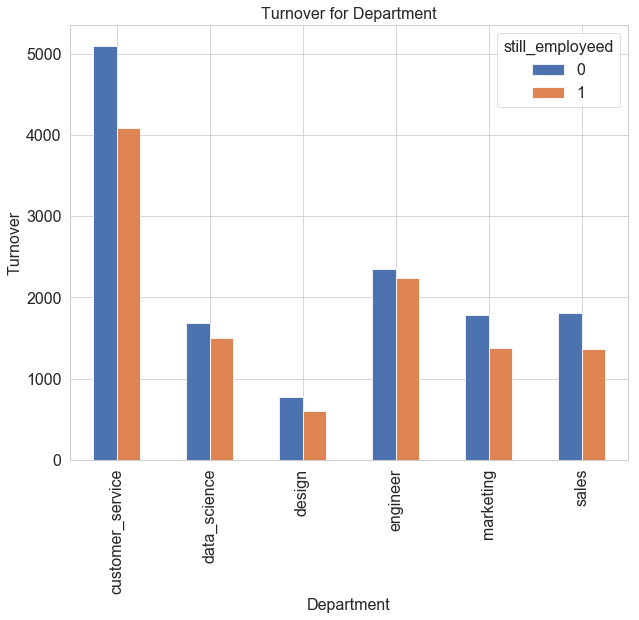

In [49]:
# Swithcing back to large/whole dataset, visualize relationship between dept and binary turnover classification (big picture - just sitll employed or not/binary, not tenure classification as above).
pd.crosstab(dc1_NEW.dept,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover for Department')
plt.xlabel('Department')
plt.ylabel('Turnover')

# CONCLUDE:
# Maybe, the gap between those who have left (0) and those who have stayed (1) at the company is larger in the customer service dept.

Text(0, 0.5, 'Turnover')

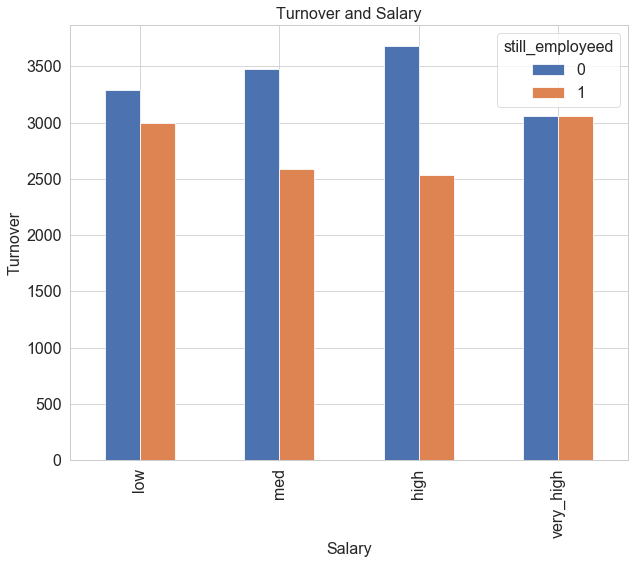

In [50]:
# Salary and turnover classification (still employeed or not)
pd.crosstab(dc1_NEW.salary_rank,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover and Salary')
plt.xlabel('Salary')
plt.ylabel('Turnover')

# CONCLUDE:
# Maybe, the gap between those who quit and those who are still working is larger for people at the middle range salary levels than the lowest and highest ranges.

Text(0, 0.5, 'Turnover')

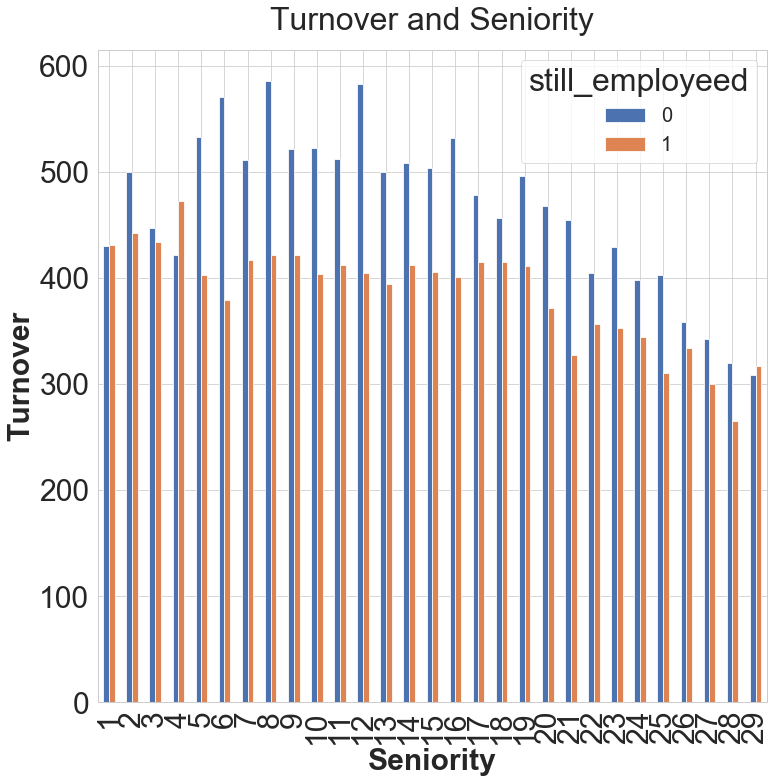

In [235]:
# Seniority and turnover classification (still employeed or not)
plt.rcParams['figure.figsize'] = (12.0, 12.0)
pd.crosstab(dc1_NEW.seniority,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover and Seniority')
plt.xlabel('Seniority')
plt.ylabel('Turnover')

# CONCLUDE:
# Not a super striking pattern, but maybe for mid-range seniority levels 5-20 years, there's more people who have left vs who have stayed?
# Only instance where more people stayed than left is 4 years experience.

In [65]:
# OK! Now we've looked at the data and are ready to get started with analyses with either a continuous or categorical Y.
# A categorical Y/outcome could be the multiple tenure categories or the binary tenure categories.
dc1_NEW.head(20)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont,tenure_category,still_employeed,salary_rank
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0,1-2yr,0,med
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0,<1yr,0,high
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0,4+yrs,1,med
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0,1-2yr,0,med
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0,2-3yr,0,very_high
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578 days,578,2012,1,578.0,1-2yr,0,high
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,NaT,currently_employeed,2013,10,1850.0,4+yrs,1,med
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,NaT,currently_employeed,2014,3,1850.0,4+yrs,1,low
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047 days,1047,2012,12,1047.0,2-3yr,0,high
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaT,currently_employeed,2012,6,1850.0,4+yrs,1,med


In [73]:
# I have a dataframe called 'dc1_NEW' that includes all 12 companies.

# But, because company 11 and 12 seem to be very different from the rest, I may want to also have a dataframe to build my models from that is just companies 1-10.

reduced_companies_df = dc1_NEW[dc1_NEW.company_id <= 10]
reduced_companies_df.head(20)
#reduced_companies_df['company_id'].unique() # double check that this did what I asked for.

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont,tenure_category,still_employeed,salary_rank
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0,1-2yr,0,med
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0,<1yr,0,high
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0,4+yrs,1,med
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0,1-2yr,0,med
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0,2-3yr,0,very_high
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578 days,578,2012,1,578.0,1-2yr,0,high
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,NaT,currently_employeed,2013,10,1850.0,4+yrs,1,med
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,NaT,currently_employeed,2014,3,1850.0,4+yrs,1,low
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047 days,1047,2012,12,1047.0,2-3yr,0,high
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaT,currently_employeed,2012,6,1850.0,4+yrs,1,med


In [ ]:
# Now I also have a dataframe called 'reduced_companies_df' that includes just companies 1-10.

In [ ]:
########## MODELING PORTION OF NB STARTS HERE ########## ---> 

In [97]:
# I will first define the X array and the Y/target variable in two sets from the reduced_companies_df dataset using the tenure_category as the output/predicted/target:
# 'Can I determine whether someone stays at a company for less than a year, 1-2 years, 2-3 years, 3-4 years, or longer than 4 years based on the predictors I have been given or new predictors I can come up with"?

y = reduced_companies_df[['tenure_category']]

# I decided not to include company ID as a predictor here since I presumably want to be able to extrapolate this out beyond a single company and first look for broad trends/predictors of tenure duration.
# will use continuous values of salary here, first instead of the categorical salary column that I created.

X = reduced_companies_df[['dept','seniority', 'salary', 'start_year', 'start_month']]

In [98]:
# Check new X df
X.head()
#X.shape

,dept,seniority,salary,start_year,start_month
0,customer_service,28,89000.0,2014,3
1,marketing,20,183000.0,2013,4
2,marketing,14,101000.0,2014,10
3,customer_service,20,115000.0,2012,5
4,data_science,23,276000.0,2011,10


In [99]:
# Check new y dataframe
y.head()
y.shape

(24638, 1)

In [100]:
# Get dummy variables for categorical features; use drop_first to get rid of the extra column when creating dummies.
X = pd.concat([X,pd.get_dummies(X['dept'], prefix='dept', drop_first=True)],axis=1)
X.head()

# drop old dept column since it is no longer informative.
X = X.drop(['dept'], axis=1)
X.head()

,seniority,salary,start_year,start_month,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,2014,3,0,0,0,0,0
1,20,183000.0,2013,4,0,0,0,1,0
2,14,101000.0,2014,10,0,0,0,1,0
3,20,115000.0,2012,5,0,0,0,0,0
4,23,276000.0,2011,10,1,0,0,0,0


In [101]:
#check new X dataframe
X.shape

(24638, 9)

In [102]:
# Import modules and libraries for modeling

from sklearn.model_selection import train_test_split # to create the split in training and test set
from sklearn.model_selection import RandomizedSearchCV # test a bunch of parameter values for classifier
from sklearn.model_selection import GridSearchCV # hone in on exact parameter values to further tune after randomgrid
from sklearn.model_selection import cross_val_score # to get performance in the 5 (or other) fold CV to optimize parameter selection for model performance 
from sklearn import metrics # to be able to use recall and any other metric for model performance in optimization
from sklearn.metrics import classification_report # nice format to show all model performance metrics against each other
from sklearn.metrics import confusion_matrix # classic TP/FP assessment
from sklearn.metrics import roc_curve # another metric of performance for comparing models

In [103]:
# create training and test data sets based on X and y defined above. Will set test set size to 20% of data with stratefication so that the different tenure groups are distributed evenly within and across the sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11,stratify = y)

In [104]:
# take a look at the new X_train, X_test, y_train, and y_test
X_train.head()
X_train.shape

(19710, 9)

In [105]:
X_test.shape

(4928, 9)

In [106]:
y_train.shape

(19710, 1)

In [107]:
y_test.shape
y_test.head()

,tenure_category
4396,<1yr
20473,2-3yr
9680,4+yrs
21359,4+yrs
15854,4+yrs


In [108]:
# Check for class imbalance, which could affect model performance metrics like accuracy.
y_train.tenure_category.value_counts()

4+yrs    9181
1-2yr    4654
<1yr     2625
2-3yr    2170
3-4yr    1080
Name: tenure_category, dtype: int64

In [109]:
y_test.tenure_category.value_counts()

4+yrs    2296
1-2yr    1163
<1yr      656
2-3yr     543
3-4yr     270
Name: tenure_category, dtype: int64

In [110]:
# Determine that there is a pretty big class imbalance: i will use smote to balance the classes by synthetic oversampling before I perform model training.

import imblearn as imblearn # for SMOTE applied to training set only
from imblearn.over_sampling import SMOTE # for SMOTE applied to training set only
from collections import Counter # to easily check old and new class sizes

sm = SMOTE(random_state=11) 
X_res_train, y_res_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_train)) 


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({'1-2yr': 9181, '4+yrs': 9181, '<1yr': 9181, '2-3yr': 9181, '3-4yr': 9181})


In [114]:
# Check new df
y_res_train.shape
#y_res_train

(45905,)

In [116]:
# Check new df
X_res_train.shape
#X_res_train

(45905, 9)

In [ ]:
# Great! Now I'm ready to run some classifier models. Can't use logistic regression with the categorical tenure outcome variable, because my outcome is not binary. But I can use Randomforest or another ensemble method. Let's start with RF.
# I won't do any recursive feature selection to begin because there's already such a reduced set of variables. 
# Start by defining some randomized search parameters for hyperparameter tuning followed by cross validation on the training set and then predictions on the held out test set (20% of data).

In [144]:
# parameters that CAN be set in RF classifier; set up random space over which to search for optimal hyperparameter values:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 2, 4, 8]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 25]
# Method of selecting samples for training each tree
#bootstrap = [True] 

In [145]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [10, 32, 55, 77, 100], 'max_features': ['auto', 'sqrt', 2, 4, 8], 'max_depth': [2, 10, None], 'min_samples_split': [10, 50], 'min_samples_leaf': [5, 10, 25], 'bootstrap': [True]}


In [146]:
from sklearn.ensemble import RandomForestClassifier

# Use the random grid to search for best hyperparameters
# First create the base model to tune
RF = RandomForestClassifier()
#RF.fit(X_res_train, y_res_train)
#y_pred=RF.predict(X_test)
#print(classification_report(y_test, y_pred))


# Random search of parameters, using 5 fold cross validation, on the training set; I will use accuracy since I've applied SMOTE to balance classes but will also look at full classfication reports after the model is run.
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')

In [147]:
# Fit the random search model to the SMOTE adjusted training data set
RF_random.fit(X_res_train, y_res_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 32, 55, 77, 100], 'max_features': ['auto', 'sqrt', 2, 4, 8], 'max_depth': [2, 10, None], 'min_samples_split': [10, 50], 'min_samples_leaf': [5, 10, 25], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [148]:
# Get the best parameters from the randomized search
RF_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 8,
 'max_depth': None,
 'bootstrap': True}

In [149]:
# Run cross validation using the best parameters and then average them to get an idea of possible performance of the classifier on "novel" data.
CV_scores = cross_val_score(RF_random, X_res_train, y_res_train, cv=5, scoring = 'accuracy')
print(CV_scores)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.8min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.1min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.9min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.9min finished


[0.43048449 0.60141612 0.64858388 0.61448802 0.61023965]


In [150]:
print("Accuracy of A RF classifier in Cross Validation: %0.2f (+/- %0.2f)" % (CV_scores.mean(), CV_scores.std() * 2))

Accuracy of A RF classifier in Cross Validation: 0.58 (+/- 0.15)


In [151]:
print(classification_report(y_test, y_pred))
# Not very good performance but notice that the model has an easier time classifying the 4+ group, which are the people who are still working at the company.
# Maybe it would be easier to lump everyone who has quit (groups <1year up to 3-4years) and compare classification with the 4+ group.

              precision    recall  f1-score   support

       1-2yr       0.33      0.37      0.35      1163
       2-3yr       0.20      0.20      0.20       543
       3-4yr       0.20      0.24      0.22       270
       4+yrs       0.71      0.70      0.70      2296
        <1yr       0.18      0.12      0.14       656

   micro avg       0.46      0.46      0.46      4928
   macro avg       0.32      0.33      0.32      4928
weighted avg       0.46      0.46      0.46      4928



In [152]:
# Showign the breakdown of classification with this RF model.
confusion_matrix(y_test, y_pred)

array([[ 432,  168,  106,  315,  142],
       [ 222,  111,   60,   97,   53],
       [  96,   62,   65,   21,   26],
       [ 364,  125,   53, 1604,  150],
       [ 207,   89,   48,  233,   79]])

In [153]:
print('Accuracy of A RF classifier on Test Set:', metrics.accuracy_score(y_test,y_pred))

Accuracy of A RF classifier on Test Set: 0.4648944805194805


In [162]:
# Re-run the model with parameters that I found above in randomized search:

# {'n_estimators': 100,
 #'min_samples_split': 10,
 #'min_samples_leaf': 5,
 #'max_features': 8,
 #'max_depth': None,
 #'bootstrap': True}
    
RF_test = RandomForestClassifier(n_estimators=100, min_samples_split=10, min_samples_leaf=5, max_features = 8, random_state = 11)
#RF_test = RandomForestClassifier()
RF_test.fit(X_res_train, y_res_train)
y_pred=RF_test.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       1-2yr       0.33      0.37      0.35      1163
       2-3yr       0.20      0.20      0.20       543
       3-4yr       0.21      0.32      0.25       270
       4+yrs       0.72      0.74      0.73      2296
        <1yr       0.18      0.08      0.11       656

   micro avg       0.48      0.48      0.48      4928
   macro avg       0.33      0.34      0.33      4928
weighted avg       0.47      0.48      0.47      4928



In [163]:
# For this poorly performing model we can get an idea of which features might matter more than others:
names = X.columns
feature_imp = pd.Series(RF_test.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

start_year           0.390510
salary               0.224351
seniority            0.146317
start_month          0.141169
dept_sales           0.023781
dept_marketing       0.021610
dept_engineer        0.019929
dept_data_science    0.019435
dept_design          0.012898
dtype: float64

No handles with labels found to put in legend.


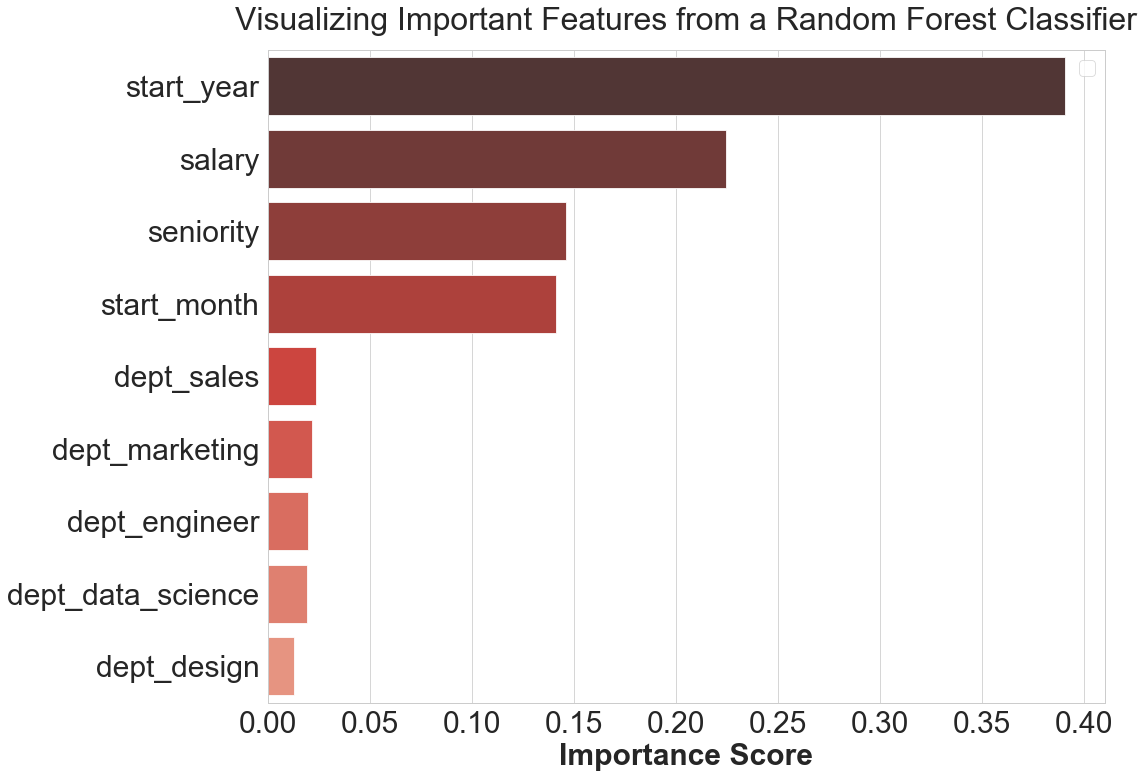

In [164]:
# Plot feature imporance values from the RF classfier.

from matplotlib import rcParams

names = X.columns

feature_imp = pd.Series(RF_test.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams["axes.labelsize"] = 30
rcParams['axes.titlepad'] = 20 
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":32,"axes.titlesize":32,"axes.labelsize":30, "legend.fontsize": 20, "xtick.labelsize": 30, "ytick.labelsize": 30})

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Reds_d')
# Add labels to your graph
plt.xlabel('Importance Score')
#plt.ylabel('Features')
plt.title("Visualizing Important Features from a Random Forest Classifier")
plt.legend()

In [ ]:
# Summary: the RF model does not do particularly well at predicting employee tenure with the exception that it does best at predicting employees that are there for more than 4 years.
# Maybe, it would be better to predict based on the binary - quit or stayed (e.g. are you currently employeed or did you quit). 
# this means we could use an outcome variable like 'still_employeed' and apply logistic regression or another RF classification.
# another alternative route would be to use days employeed as a continous outcome (e.g., linear regression) in which case we would need to use the smaller data set of just people who have quit, since they have meaninful values of days employeed (compared to the people who are still employeed).


In [165]:
# A quick reminder about the df: I will again use the reduced set of 10 companies for the next steps/modeling approaches.

reduced_companies_df.head(20)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,total_tenure,days_employeed,start_year,start_month,days_employeed_cont,tenure_category,still_employeed,salary_rank
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585 days,585,2014,3,585.0,1-2yr,0,med
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340 days,340,2013,4,340.0,<1yr,0,high
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaT,currently_employeed,2014,10,1850.0,4+yrs,1,med
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389 days,389,2012,5,389.0,1-2yr,0,med
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040 days,1040,2011,10,1040.0,2-3yr,0,very_high
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578 days,578,2012,1,578.0,1-2yr,0,high
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaT,NaT,currently_employeed,2013,10,1850.0,4+yrs,1,med
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaT,NaT,currently_employeed,2014,3,1850.0,4+yrs,1,low
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23,1047 days,1047,2012,12,1047.0,2-3yr,0,high
9,504159.0,1,sales,7,104000.0,2012-06-12,NaT,NaT,currently_employeed,2012,6,1850.0,4+yrs,1,med


In [166]:
# Here the outcome/predicted variable will be binary, still employeed or not.
y = reduced_companies_df[['still_employeed']]

# I decided not to include company ID as a predictor here since I presumably want to be able to extrapolate this out beyond a single company and first look for broad trends/predictors of tenure duration.
# will use continuous values of salary here, first instead of the categorical salary column that I created.

X = reduced_companies_df[['dept','seniority', 'salary', 'start_year', 'start_month']]

In [167]:
y.head()

,still_employeed
0,0
1,0
2,1
3,0
4,0


In [168]:
y.shape

(24638, 1)

In [169]:
X.head()

,dept,seniority,salary,start_year,start_month
0,customer_service,28,89000.0,2014,3
1,marketing,20,183000.0,2013,4
2,marketing,14,101000.0,2014,10
3,customer_service,20,115000.0,2012,5
4,data_science,23,276000.0,2011,10


In [170]:
# get dummy variables; use drop_first to get rid of the extra column when creating dummies.
X = pd.concat([X,pd.get_dummies(X['dept'], prefix='dept', drop_first=True)],axis=1)
X.head()

# drop old dept column since it is no longer informative.
X = X.drop(['dept'], axis=1)
X.head()

,seniority,salary,start_year,start_month,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,28,89000.0,2014,3,0,0,0,0,0
1,20,183000.0,2013,4,0,0,0,1,0
2,14,101000.0,2014,10,0,0,0,1,0
3,20,115000.0,2012,5,0,0,0,0,0
4,23,276000.0,2011,10,1,0,0,0,0


In [171]:
# create training and test data sets based on X and y defined above. Will set test set size to 20% of data with stratefication so that the different tenure groups are distributed evenly within and across the sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11,stratify = y)

In [173]:
# check for class imbalance 
y_train.still_employeed.value_counts()

0    10781
1     8929
Name: still_employeed, dtype: int64

In [175]:
# Class imbalance is not too bad here, but I will apply SMOTE anyway, to give us the best chances of being able to predict both groups.
sm = SMOTE(random_state=11) 
X_res_train, y_res_train = sm.fit_resample(X_train, y_train.values.ravel())
print('Resampled dataset shape %s' % Counter(y_res_train)) 

Resampled dataset shape Counter({'1': 10781, '0': 10781})


In [176]:
# Now we are ready now to try logistic regression and then RF with this binary outcome variable. First, let's see if I can improve the previous RF.

RF = RandomForestClassifier()
RF.fit(X_res_train, y_res_train)
y_pred=RF.predict(X_test)
print(classification_report(y_test, y_pred))

# Not too bad! no parameter tuning at this point and already doing better than the previous model where I was predicting +2 classes.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.75      0.81      0.78      2696
           1       0.75      0.67      0.71      2232

   micro avg       0.75      0.75      0.75      4928
   macro avg       0.75      0.74      0.75      4928
weighted avg       0.75      0.75      0.75      4928



In [177]:
confusion_matrix(y_test, y_pred)

array([[2194,  502],
       [ 726, 1506]])

In [179]:
print('Overall accuracy of a binary RF classifier on the Test Set:', metrics.accuracy_score(y_test,y_pred))

Overall accuracy of a binary RF classifier on the Test Set: 0.7508116883116883


In [180]:
names = X.columns
feature_imp = pd.Series(RF.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

start_year           0.481252
salary               0.259028
seniority            0.141801
start_month          0.086294
dept_marketing       0.007004
dept_engineer        0.006501
dept_sales           0.006479
dept_data_science    0.006001
dept_design          0.005639
dtype: float64

No handles with labels found to put in legend.


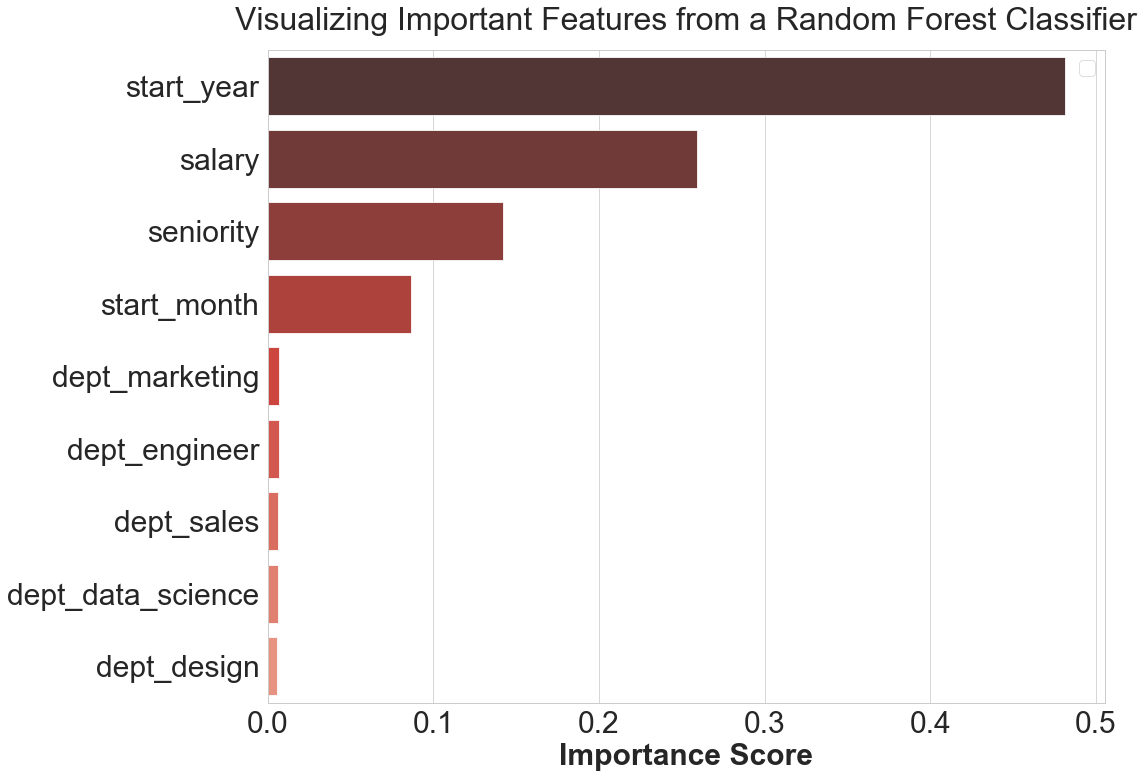

In [181]:
names = X.columns

feature_imp = pd.Series(RF.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams["axes.labelsize"] = 30
rcParams['axes.titlepad'] = 20 
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":32,"axes.titlesize":32,"axes.labelsize":30, "legend.fontsize": 20, "xtick.labelsize": 30, "ytick.labelsize": 30})

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Reds_d')
# Add labels to your graph
plt.xlabel('Importance Score')
#plt.ylabel('Features')
plt.title("Visualizing Important Features from a Random Forest Classifier")
plt.legend()

In [195]:
# Summary up to here: I could now tune the hyperparameters of this RF before moving on, but I'd like to see how logistic regression performs since it is more interpretable.

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
#logreg.fit(X_res_train, y_res_train)
#y_pred = logreg.predict(X_test)
#logreg.score(X_test,y_test)



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5355113636363636

In [186]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

In [187]:
# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring = 'accuracy')

In [188]:
logreg_cv.fit(X_res_train, y_res_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWar

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWar

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([1.00000e-05, 8.48343e-05, 7.19686e-04, 6.10540e-03, 5.17947e-02,
       4.39397e-01, 3.72759e+00, 3.16228e+01, 2.68270e+02, 2.27585e+03,
       1.93070e+04, 1.63789e+05, 1.38950e+06, 1.17877e+07, 1.00000e+08]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [189]:
logreg_cv.best_params_

{'C': 268.2695795279727, 'penalty': 'l1'}

In [190]:
CV_scores = cross_val_score(logreg, X_res_train, y_res_train, cv=5, scoring = 'accuracy')
print(CV_scores)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.5336115  0.5403525  0.52017625 0.50834879 0.53200371]


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [191]:
print("Accuracy of A logistic regression classifier in Cross Validation: %0.2f (+/- %0.2f)" % (CV_scores.mean(), CV_scores.std() * 2))

Accuracy of A logistic regression classifier in Cross Validation: 0.53 (+/- 0.02)


In [192]:
print('Accuracy of A logistic regression classifier on the Test Set:', metrics.accuracy_score(y_test,y_pred))

Accuracy of A logistic regression classifier on the Test Set: 0.5355113636363636


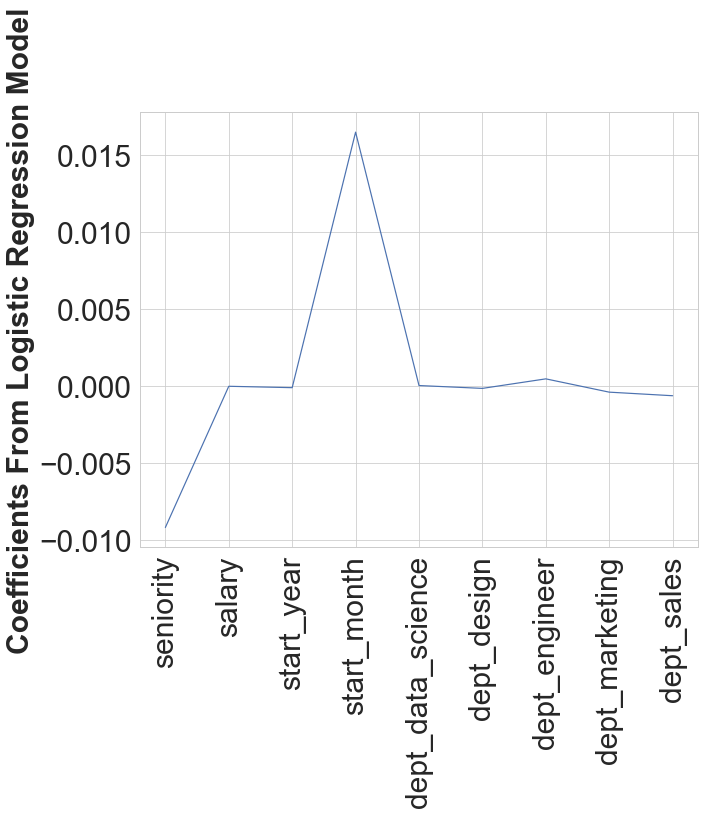

In [196]:
coef = logreg.coef_[0]
names = X.columns
plt.rcParams['figure.figsize'] = (10.0, 8.0)
_ = plt.plot(range(len(names)), coef)
_ = plt.xticks(range(len(names)),names, rotation = 90)
_ =plt.ylabel('Coefficients From Logistic Regression Model')
plt.show()

# start year and start month is important in both the RF and logreg models. There's not much companies can do about year, since that's in the past. But it might tell them that there's something about a certain cohort of individuals that they cannot do anything about.

In [ ]:
# So it appears that the logistic regression model performs less well than the random forest classifier. And, it also appears that the tuned logreg model performs as well as the non-tuned model (but this could be due to the hyperparameter space over which I'm searching).
# I will now go back to the RF classifier and look a little bit deeper at what the feature imporance scores are telling us.

In [198]:
# Go back to the binary random forest classifier and do some hyperparameter tuning.

RF = RandomForestClassifier()


In [201]:
# parameters that CAN be set in RF classifier:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 6)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 2, 4, 8]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 50]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 25]
# Method of selecting samples for training each tree
#bootstrap = [True] 

In [202]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [10, 208, 406, 604, 802, 1000], 'max_features': ['auto', 'sqrt', 2, 4, 8], 'max_depth': [2, 10, None], 'min_samples_split': [10, 50], 'min_samples_leaf': [5, 10, 25], 'bootstrap': [True]}


In [203]:
# Random search of parameters, using 5 fold cross validation, on the training set
RF_random = RandomizedSearchCV(estimator = RF, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model to the SMOTE adjusted training data set
RF_random.fit(X_res_train, y_res_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 16.4min
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 22.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [10, 208, 406, 604, 802, 1000], 'max_features': ['auto', 'sqrt', 2, 4, 8], 'max_depth': [2, 10, None], 'min_samples_split': [10, 50], 'min_samples_leaf': [5, 10, 25], 'bootstrap': [True]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [204]:
RF_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [205]:
CV_scores = cross_val_score(RF_random, X_res_train, y_res_train, cv=5, scoring = 'accuracy')
print(CV_scores)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.7min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.0min
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.0min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.4min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 13.1min
/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.4min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 17.5min finished


[0.78789986 0.80612245 0.78501855 0.79754174 0.81864564]


In [208]:
print("Average accuracy of a tuned classifier in 5-fold cross validation on the training data set : %0.2f (+/- %0.2f)" % (CV_scores.mean(), CV_scores.std() * 2))

Average accuracy of a tuned classifier in 5-fold cross validation on the training data set : 0.80 (+/- 0.02)


In [209]:
print('Accuracy of A logistic regression classifier on the held out test data set:', metrics.accuracy_score(y_test,y_pred))

Accuracy of A logistic regression classifier on the held out test data set: 0.7508116883116883


In [ ]:
# The hyperparameter tuning applied to this RF classifier on a binary outcome (quit vs. still employeed) did not really improve performance on the unseen test data set.

In [210]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      2696
           1       0.75      0.67      0.71      2232

   micro avg       0.75      0.75      0.75      4928
   macro avg       0.75      0.74      0.75      4928
weighted avg       0.75      0.75      0.75      4928



In [213]:
# here is a list of the best parameters for the model:
#{'n_estimators': 1000,
 #'min_samples_split': 10,
 #'min_samples_leaf': 5,
 #'max_features': 'auto',
 #'max_depth': 10,
 #'bootstrap': True}

# fit a model with the parameters that were found so that I can get the feature imporance scores:
RF_test = RandomForestClassifier(n_estimators=1000, min_samples_split=10, min_samples_leaf=5, max_depth=10, random_state = 11)
RF_test.fit(X_res_train, y_res_train)
y_pred=RF_test.predict(X_test)
print(classification_report(y_test, y_pred))

# so somehow with this random state the performance was just slightly better than before (this is just random).

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      2696
           1       0.79      0.72      0.75      2232

   micro avg       0.79      0.79      0.79      4928
   macro avg       0.79      0.78      0.78      4928
weighted avg       0.79      0.79      0.79      4928



In [214]:
# Get final model feature imporance values and then plot
names = X.columns
feature_imp = pd.Series(RF_test.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

start_year           0.874300
salary               0.047493
start_month          0.032968
seniority            0.022776
dept_engineer        0.006700
dept_data_science    0.005563
dept_sales           0.004785
dept_marketing       0.003260
dept_design          0.002155
dtype: float64

Text(0.5, 1.0, 'Visualizing Important Features from a Random Forest Classifier')

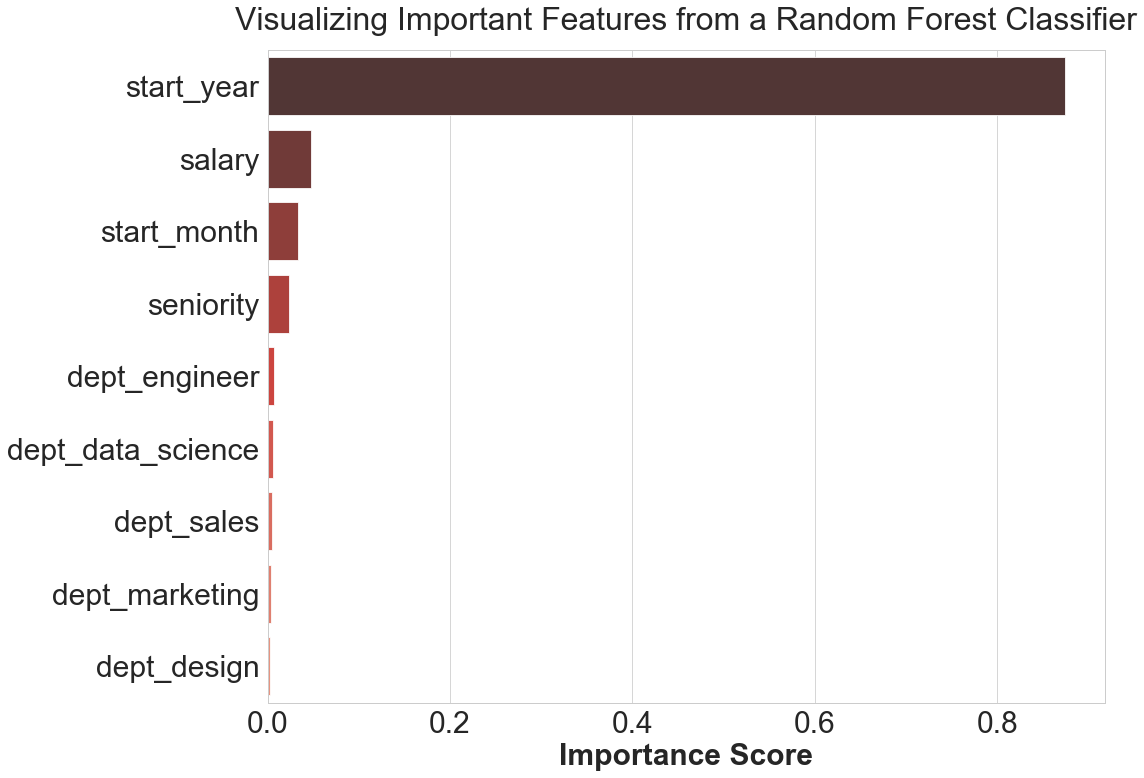

In [215]:
names = X.columns

feature_imp = pd.Series(RF_test.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['axes.labelweight'] = 'bold'
#plt.rcParams["axes.labelsize"] = 30
rcParams['axes.titlepad'] = 20 
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":32,"axes.titlesize":32,"axes.labelsize":30, "legend.fontsize": 20, "xtick.labelsize": 30, "ytick.labelsize": 30})

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Reds_d')
# Add labels to your graph
plt.xlabel('Importance Score')
#plt.ylabel('Features')
plt.title("Visualizing Important Features from a Random Forest Classifier")

In [ ]:
# OVERALL SUMMARY AND RESPONSES TO GOAL AND HINT QUESTIONS: 
# A random forest classifier was used to predict whether an employee is still working or has left a company. This RF classifier model appears to peform better than a logistic regression model, but it's possible that a logistic model could have been tuned over wider hyperparameter space, or that we could have applied 'one versus all' to the multiple tenure category group (based on # of years employees were at the company).

##############################################################

#### Caveats: 
# I have tried includeing and excluding company ID in my predictive models. It did not appear to do much in terms of improving predictions about who quit/stayed and including company (as many categorical dummy variables) seems to greatly increase feature space for no real gain.
# I also did not include number of days as a covariate or run a regression model with number of days employeed as a continuous predictor; this might have improved performance.
# In most of my analyses here, I used start year to potentiall explain stochasticity among years (due to some external factor that might affect cohort), however, I think that this was just picking up a false signal, having to do with timing of surveying employees. So, see final analysis and feature imporance plot at the very end of this document without year, if interested.

##############################################################

#### The goal was to predict employee retention and understand its main drivers. 
# According to the RF model the main drivers of whether an employee was retained or not include: start year (but discount this for now and see final point in this section), salary, seniority, and start month. Department seems to make no difference.
# In terms of salary: Employees at medium and high salary levels (compared to low and very high) have highest difference in # who have quit vs stayed. More have quit than have stayed. Maybe if salary is driving this decision, there need to be more opportunities for small incremental increases in salary as incentives?
# In terms of seniority: Again, employees within the mid-range seniority category (more than 5 years of experience and less than 20) seem to possibly have a higher # of quit vs current employees. Perhaps target this middle group in some way to provide incentives to stay (bonus? do they get to move up in status?) 
# In terms of start month: Only real anomoly is November; people whose hire date falls in November are within a cohort that is defined by more people who have stayed than left. 

# If you look at the further exploratory analysis below, you can see that really, year of sampling is giving the wrong impression. The fact that this is important just reflects that when the survey of employees was taken, there were more likley to be more people who were employeed (vs. those who quit) at the more recent timepoints.

##############################################################

#### Further questions:

## What are the main factors that drive employee churn? Do they make sense?
# We really need more information, but it seems like incentives for mid-range salary and seniority groups could help with retaining more poeple in those categories.

## What might you be able to do for the company to address employee Churn, what would be follow-up actions?
# Ask for more information about employees themselves. We do not have data from very far past. 

## If you could add to this data set just one variable that could help explain employee churn, what would that be?
# I would want some information about rate of change in salary as well as some information about employee satisfaction, number of promotions, level of responsibility/hierarchy within their department (were they a manager, etc.); essentially I would like greater resolution about the employees themselves.


In [ ]:
########## FURTHER INVESTIGATION BELOW (EXTRA) ########## --> 

In [229]:
#dc1_NEW.head(20)

In [218]:
# Further exploration: 
# RF model with company included and all 12 companies.
# Here the outcome/predicted variable will be binary, still employeed or not.
y = dc1_NEW[['still_employeed']]

# Here I use the full company set (1-12) company ID. 
X = dc1_NEW[['company_id','dept','seniority', 'salary', 'start_year', 'start_month']]


In [219]:
# Get dummy variables for categorical features; use drop_first to get rid of the extra column when creating dummies.
X = pd.concat([X,pd.get_dummies(X['dept'], prefix='dept', drop_first=True)],axis=1)
X = pd.concat([X,pd.get_dummies(X['company_id'], prefix='company', drop_first=True)],axis=1)

# drop old dept column since it is no longer informative.
X = X.drop(['dept'], axis=1)
X = X.drop(['company_id'], axis=1)
X.head()

,seniority,salary,start_year,start_month,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,company_10,company_11,company_12
0,28,89000.0,2014,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,20,183000.0,2013,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,14,101000.0,2014,10,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,20,115000.0,2012,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,23,276000.0,2011,10,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [220]:
# create training and test data sets based on X and y defined above. Will set test set size to 20% of data with stratefication so that the different tenure groups are distributed evenly within and across the sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11,stratify = y)

In [221]:
# check for class imbalance 
y_train.still_employeed.value_counts()

0    10801
1     8941
Name: still_employeed, dtype: int64

In [222]:
sm = SMOTE(random_state=11) 
X_res_train, y_res_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_train)) 

Resampled dataset shape Counter({'0': 10801, '1': 10801})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [225]:
# just try an out-of-the box RF here to see how it performs compared to previous model w/out company ID and full company set.

RF = RandomForestClassifier()
RF.fit(X_res_train, y_res_train)
y_pred=RF.predict(X_test)
print(classification_report(y_test, y_pred))
# performance is about equal - maybe a little bit better, but lots more features since the 12 companies have to be turned into dummy variables.

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.76      0.84      0.80      2700
           1       0.78      0.68      0.72      2236

   micro avg       0.76      0.76      0.76      4936
   macro avg       0.77      0.76      0.76      4936
weighted avg       0.77      0.76      0.76      4936



In [226]:
print('Overall accuracy of a binary RF classifier on the Test Set:', metrics.accuracy_score(y_test,y_pred))

Overall accuracy of a binary RF classifier on the Test Set: 0.7647893030794165


In [227]:
# Get feature imporance values and then plot
names = X.columns
feature_imp = pd.Series(RF.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

start_year           0.454974
salary               0.204059
seniority            0.129628
start_month          0.102820
company_2            0.013910
dept_marketing       0.009270
company_3            0.009185
dept_engineer        0.008783
company_4            0.007978
dept_sales           0.007902
company_5            0.007783
dept_data_science    0.007013
company_6            0.006659
company_7            0.006651
dept_design          0.005853
company_10           0.005708
company_9            0.005627
company_8            0.005559
company_12           0.000321
company_11           0.000315
dtype: float64

Text(0.5, 1.0, 'Visualizing Important Features from a Random Forest Classifier')

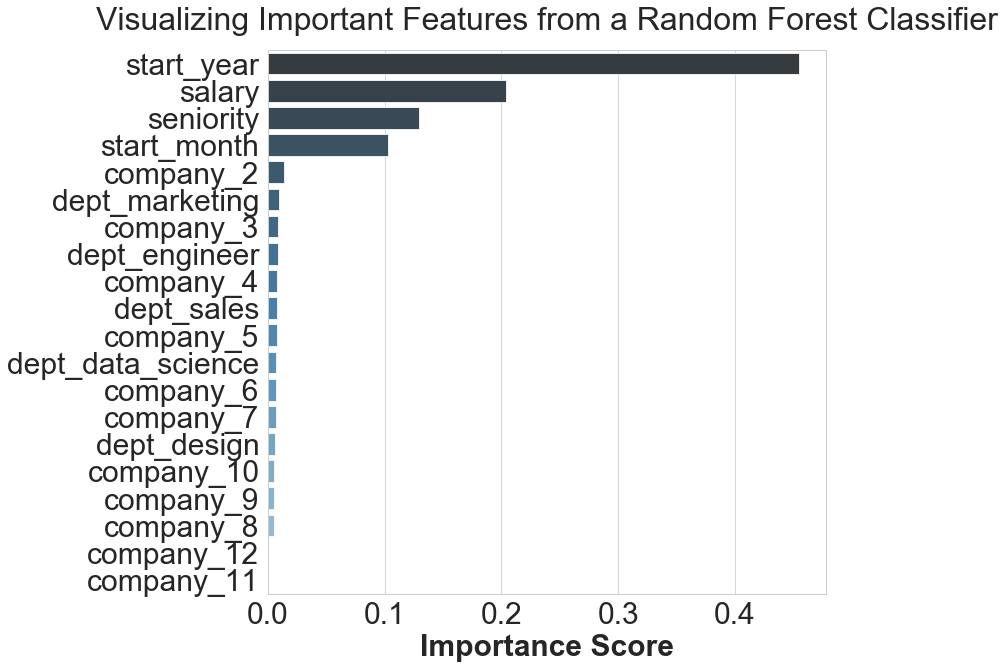

In [231]:
names = X.columns

feature_imp = pd.Series(RF.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlepad'] = 20 
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":32,"axes.titlesize":32,"axes.labelsize":30, "legend.fontsize": 20, "xtick.labelsize": 30, "ytick.labelsize": 30})

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Blues_d')
# Add labels to your graph
plt.xlabel('Importance Score')
#plt.ylabel('Features')
plt.title("Visualizing Important Features from a Random Forest Classifier")

In [ ]:
# Overall, same features are important -- start year appears to be really driving trends and I may want to discuss whether to keep this in the model since it's a feature I choose to include as a possible stochastic factor.
# Salary and seniority appear to be the next most important. Let's look closer since this has shown up in past models. It's hard to isolate the effect here from the RF output (feature importance).
# If I had more time I could look at partial dependence plots to isolate effect of features on the binary response variable.


Text(0, 0.5, 'Turnover')

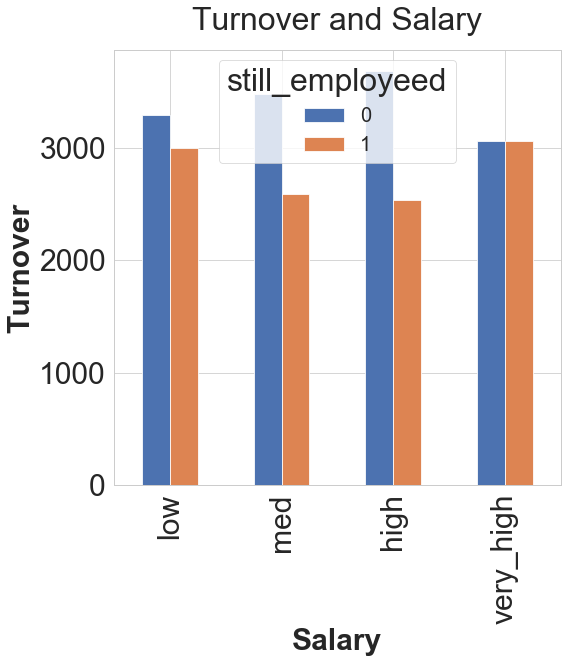

In [241]:
# Reminder: we saw this fig before -- maybe there is something here (salary has been made categorical)
# Peraps at the highest salary level, it's true that equal numbers of people are staying or going
# At medium and high salary levels, more peopole are leaving than going. Maybe they are more competative for other jobs -- maybe they are leaving to find higher salary?
# The gap between those who quit and those who are still working is larger for people at the middle range salary levels than the lowest and highest ranges.


# Salary and turnover classification (still employeed or not)
plt.rcParams['figure.figsize'] = (8, 8)
pd.crosstab(dc1_NEW.salary_rank,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover and Salary')
plt.xlabel('Salary')
plt.ylabel('Turnover')


Text(0, 0.5, 'Turnover')

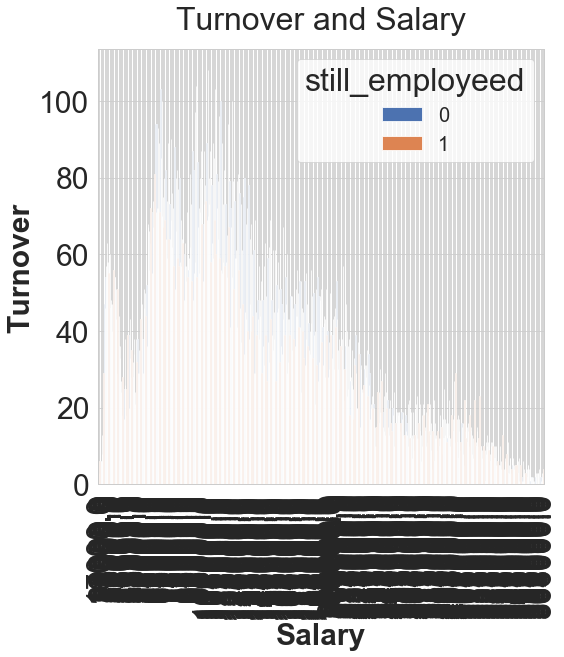

In [267]:
# Salary and turnover classification (still employeed or not)
plt.rcParams['figure.figsize'] = (8, 8)
pd.crosstab(dc1_NEW.salary,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover and Salary')
plt.xlabel('Salary')
plt.ylabel('Turnover')

In [ ]:
# Here are a couple of new visualizations for start year and month, with these effects parsed from the rest.

Text(0, 0.5, 'Turnover')

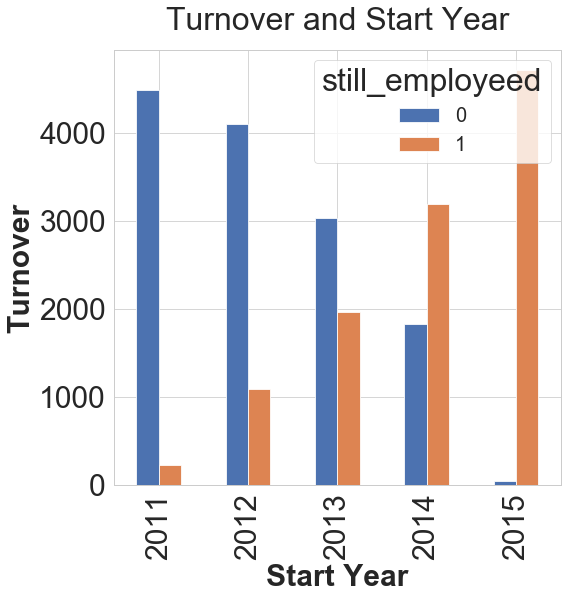

In [242]:
pd.crosstab(dc1_NEW.start_year,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover and Start Year')
plt.xlabel('Start Year')
plt.ylabel('Turnover')
# CONCLUDE:
# Including start year is sort of like an artifact. More people are likely to have quit if they started working years/months ago.
# Perhaps this should really be removed from the model, because it's giving the 'wrong' information (it's just showing a signal represented by the phenomenon that more people are still likely to be employeed at the time of the survey if they were recently hired).

Text(0, 0.5, 'Turnover')

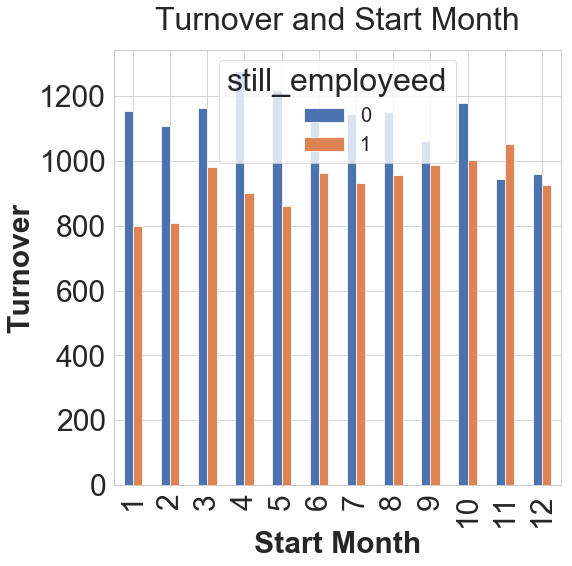

In [243]:
pd.crosstab(dc1_NEW.start_month,dc1_NEW.still_employeed).plot(kind='bar')
plt.title('Turnover and Start Month')
plt.xlabel('Start Month')
plt.ylabel('Turnover')

# CONCLUDE
# The only month where number of people who have stayed vs. left is higher is November. 

In [244]:
# One last thing... what happens when start year is removed from the final model above.

y = dc1_NEW[['still_employeed']]

# Here I use the full company set (1-12) company ID. 
X = dc1_NEW[['company_id','dept','seniority', 'salary', 'start_month']]

In [245]:
# Get dummy variables for categorical features; use drop_first to get rid of the extra column when creating dummies.
X = pd.concat([X,pd.get_dummies(X['dept'], prefix='dept', drop_first=True)],axis=1)
X = pd.concat([X,pd.get_dummies(X['company_id'], prefix='company', drop_first=True)],axis=1)

# drop old dept column since it is no longer informative.
X = X.drop(['dept'], axis=1)
X = X.drop(['company_id'], axis=1)
X.head()

,seniority,salary,start_month,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,company_10,company_11,company_12
0,28,89000.0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,20,183000.0,4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,14,101000.0,10,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
3,20,115000.0,5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,23,276000.0,10,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [247]:
# create training and test data sets based on X and y defined above. Will set test set size to 20% of data with stratefication so that the different tenure groups are distributed evenly within and across the sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=11,stratify = y)

In [248]:
# check for class imbalance 
y_train.still_employeed.value_counts()

0    10801
1     8941
Name: still_employeed, dtype: int64

In [249]:
sm = SMOTE(random_state=11) 
X_res_train, y_res_train = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res_train))

Resampled dataset shape Counter({'0': 10801, '1': 10801})


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [250]:
# just try an out-of-the box RF here to see how it performs compared to previous model w/out company ID and full company set.

RF = RandomForestClassifier()
RF.fit(X_res_train, y_res_train)
y_pred=RF.predict(X_test)
print(classification_report(y_test, y_pred))

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.56      0.64      0.60      2700
           1       0.47      0.38      0.42      2236

   micro avg       0.53      0.53      0.53      4936
   macro avg       0.51      0.51      0.51      4936
weighted avg       0.52      0.53      0.52      4936



In [251]:
print('Overall accuracy of a binary RF classifier on the Test Set:', metrics.accuracy_score(y_test,y_pred))

Overall accuracy of a binary RF classifier on the Test Set: 0.5251215559157212


In [252]:
# Get feature imporance values and then plot
names = X.columns
feature_imp = pd.Series(RF.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

salary               0.435520
seniority            0.250622
start_month          0.162833
company_2            0.020925
company_3            0.013500
dept_engineer        0.012430
company_4            0.011655
dept_sales           0.011543
company_5            0.010378
dept_marketing       0.009656
company_8            0.009457
company_7            0.009100
dept_data_science    0.009088
company_6            0.008901
dept_design          0.008119
company_10           0.007977
company_9            0.007313
company_11           0.000523
company_12           0.000462
dtype: float64

Text(0.5, 1.0, 'Visualizing Important Features from a Random Forest Classifier')

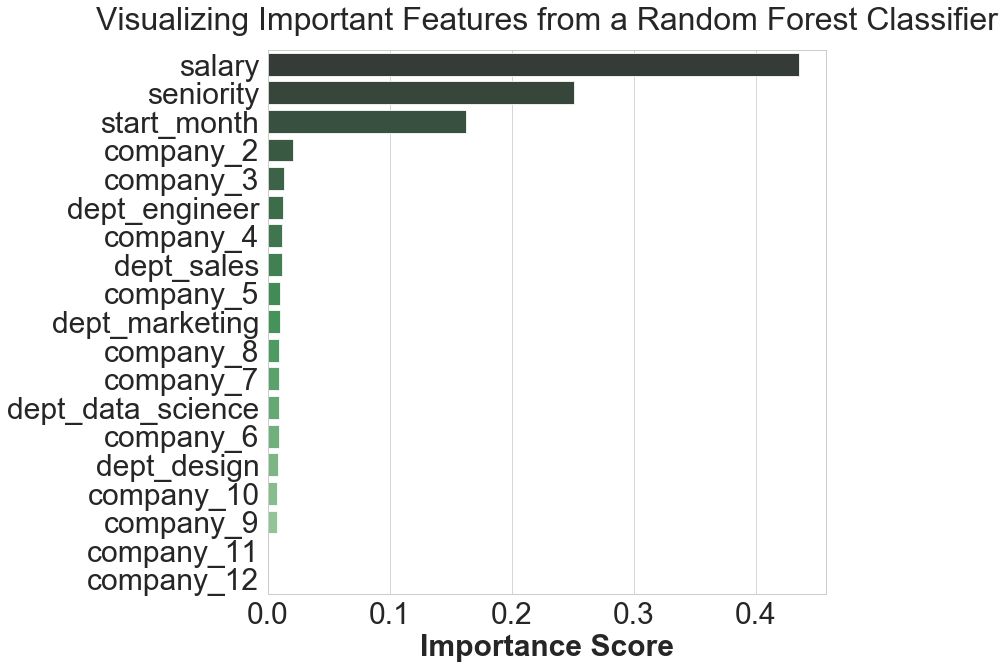

In [253]:
names = X.columns

feature_imp = pd.Series(RF.feature_importances_,index=names).sort_values(ascending=False)
feature_imp

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlepad'] = 20 
sns.set(style='whitegrid')
sns.set_context("paper", rc={"font.size":32,"axes.titlesize":32,"axes.labelsize":30, "legend.fontsize": 20, "xtick.labelsize": 30, "ytick.labelsize": 30})

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Greens_d')
# Add labels to your graph
plt.xlabel('Importance Score')
#plt.ylabel('Features')
plt.title("Visualizing Important Features from a Random Forest Classifier")

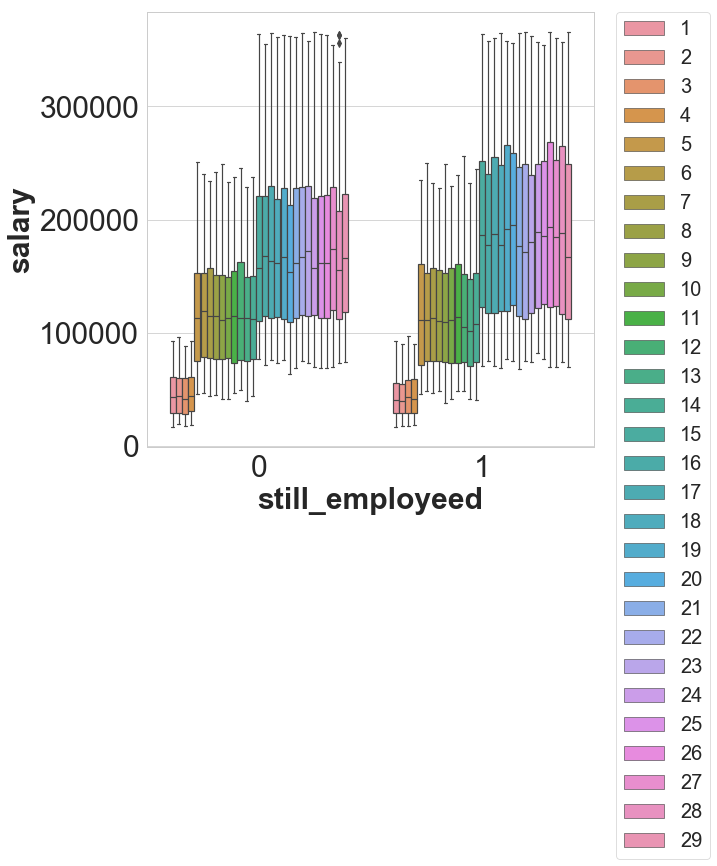

In [283]:
#Just for fun
sns.boxplot(x="still_employeed", y="salary", hue = 'seniority', data=dc1_NEW)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)